In [57]:
#specify tensorflow version to use
%tensorflow_version 2.x
#load tensorboard
#%load_ext tensorboard
 #%tensorboard --logdir logs
import tensorflow as tf
%autosave 5
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#session = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction)
#from tf.keras.layers.experimental.preprocessing import TextVectorization

Autosaving every 5 seconds


In [0]:
#drive.flush_and_unmount()

In [59]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#If you want to use the file and not have to remember to close it afterward, do this:


with open('/content/drive/My Drive/NaturalLanguageProcessing/GhanaNLP/jw300.en-tw.tw', 'r') as f:
     #Twi_data = f.readlines()
      Twi_data= f.read().splitlines()

In [61]:
Twi_data[0:5] 

['“ Oo , Yehowa , Boa Me Babea Kumaa Yi Ma Onni Nokware ! ”',
 'WƆWOO me too abusua a wonim adwinne di mu wɔ Alsace , France , wɔ 1930 mu .',
 'Ná Papa taa pa twere n’agua mu kenkan asase ho nsɛm anaa ewim nneɛma ho nhoma bi anwummere anwummere .',
 'Ná me kraman da Papa nan so , na na ɔka nsɛntitiriw a epue wɔ n’akenkan no mu kyerɛ Maame bere a ɔnwene abusua no nneɛma no .',
 'Ná m’ani gye anwummere a ɛtete saa no ho kɛse !']

In [62]:
english_data = [line.rstrip() for line in open('/content/drive/My Drive/NaturalLanguageProcessing/GhanaNLP/jw300.en-tw.en')]
english_data[0:5]

['“ Oh , Jehovah , Keep My Young Girl Faithful ! ”',
 'I WAS born in 1930 in Alsace , France , into an artistic family .',
 'During the evenings , Father , sitting in his lounge chair , would be reading some books about geography or astronomy .',
 'My doggy would be sleeping by his feet , and Daddy would be sharing with Mum some highlights from his reading while she was knitting for her family .',
 'How much I enjoyed those evenings !']

#### sequence to sequence
encoder decoder model

In [63]:
import tensorflow_addons as tfa
print(tfa.__version__)
#print(dir(tfa.seq2seq))

0.8.3


In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
# encoding=utf8
from importlib import reload
import sys
reload(sys)
#sys.setdefaultencoding('utf8')
%autosave 5

Autosaving every 5 seconds


In [0]:
def normalize_eng(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def normalize_twi(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s


# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence_english(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w




  
def preprocess_sentence_twi(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-ZɛƐɔƆ?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [66]:
type(english_data)

english_d  = list(map(preprocess_sentence_english,english_data))
english_d[0:5]

['<start> oh , jehovah , keep my young girl faithful ! <end>',
 '<start> i was born in in alsace , france , into an artistic family . <end>',
 '<start> during the evenings , father , sitting in his lounge chair , would be reading some books about geography or astronomy . <end>',
 '<start> my doggy would be sleeping by his feet , and daddy would be sharing with mum some highlights from his reading while she was knitting for her family . <end>',
 '<start> how much i enjoyed those evenings ! <end>']

In [67]:
twi_d  = list(map(preprocess_sentence_twi,Twi_data))
twi_d[0:5]

['<start> oo , yehowa , boa me babea kumaa yi ma onni nokware ! <end>',
 '<start> wɔwoo me too abusua a wonim adwinne di mu wɔ alsace , france , wɔ mu . <end>',
 '<start> na papa taa pa twere n agua mu kenkan asase ho nsɛm anaa ewim nneɛma ho nhoma bi anwummere anwummere . <end>',
 '<start> na me kraman da papa nan so , na na ɔka nsɛntitiriw a epue wɔ n akenkan no mu kyerɛ maame bere a ɔnwene abusua no nneɛma no . <end>',
 '<start> na m ani gye anwummere a ɛtete saa no ho kɛse ! <end>']

In [68]:

all_data= (twi_d[0:30000]),(english_d[0:30000])
all_data[0][0:5]

['<start> oo , yehowa , boa me babea kumaa yi ma onni nokware ! <end>',
 '<start> wɔwoo me too abusua a wonim adwinne di mu wɔ alsace , france , wɔ mu . <end>',
 '<start> na papa taa pa twere n agua mu kenkan asase ho nsɛm anaa ewim nneɛma ho nhoma bi anwummere anwummere . <end>',
 '<start> na me kraman da papa nan so , na na ɔka nsɛntitiriw a epue wɔ n akenkan no mu kyerɛ maame bere a ɔnwene abusua no nneɛma no . <end>',
 '<start> na m ani gye anwummere a ɛtete saa no ho kɛse ! <end>']

In [0]:
def create_dataset_eng(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence_english(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [0]:
#encoding = ‘utf-8-sig’ is added to overcome the issue when exporting ‘Non-English’ languages.
def create_dataset_twi(path, num_examples):
  lines = io.open(path, encoding='utf-8-sig').read().strip().split('\n')

  word_pairs = [[preprocess_sentence_twi(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [71]:
num_examples=3000
path_eng='/content/drive/My Drive/NaturalLanguageProcessing/GhanaNLP/jw300.en-tw.en' 

eng=create_dataset_eng(path_eng, num_examples)
print(eng)

In [72]:
path_twi = '/content/drive/My Drive/NaturalLanguageProcessing/GhanaNLP/jw300.en-tw.tw'
twi=create_dataset_twi(path_twi, num_examples)
print(twi)

In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_data( num_examples=None):
  # creating cleaned input, output pairs
  targ_lang  = english_d[0:num_examples]
  inp_lang =   twi_d[0:num_examples]

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# Try experimenting with the size of that dataset
num_examples = 3000
input_tensor, target_tensor, inp_lang, targ_lang = load_data( num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [77]:
print(max_length_targ)
print(max_length_inp)

113
150


In [78]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2400 2400 600 600


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [80]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
3 ----> <start>
229 ----> awiei
93 ----> koraa
12 ----> wɔ
1248 ----> september
2 ----> no
6 ----> ,
74 ----> ɔde
292 ----> too
163 ----> paapa
134 ----> anim
7 ----> sɛ
6 ----> ,
7 ----> sɛ
4107 ----> wannyae
10 ----> ne
194 ----> kristofo
242 ----> gyidi
2 ----> no
9 ----> mu
1 ----> a
6 ----> ,
1768 ----> obefi
132 ----> fie
23 ----> hɔ
5 ----> .
4 ----> <end>

Target Language; index to word mapping
1 ----> <start>
469 ----> finally
4 ----> ,
10 ----> in
1248 ----> september
4 ----> ,
43 ----> she
1944 ----> confronted
77 ----> him
19 ----> with
5 ----> the
5251 ----> ultimatum
11 ----> that
21 ----> he
145 ----> give
79 ----> up
5 ----> the
181 ----> christian
384 ----> faith
37 ----> or
564 ----> else
43 ----> she
66 ----> would
562 ----> leave
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
#BATCH_SIZE = 32
#for step in xrange(test_size / BATCH_SIZE):
#for step in xrange(test_size // BATCH_SIZE):
#In order to pass a int instead of a float to xrange and avoid a runtime exception.
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [82]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 150]), TensorShape([64, 113]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [84]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 150, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [86]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 150, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [88]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6521)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [92]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4427
Epoch 1 Loss 1.0952
Time taken for 1 epoch 610.827437877655 sec

Epoch 2 Batch 0 Loss 1.0101
Epoch 2 Loss 1.0041
Time taken for 1 epoch 450.0042235851288 sec

Epoch 3 Batch 0 Loss 0.9739
Epoch 3 Loss 0.9684
Time taken for 1 epoch 451.62801146507263 sec

Epoch 4 Batch 0 Loss 1.0080
Epoch 4 Loss 0.9505
Time taken for 1 epoch 451.20018339157104 sec

Epoch 5 Batch 0 Loss 0.8565
Epoch 5 Loss 0.9346
Time taken for 1 epoch 449.37496280670166 sec

Epoch 6 Batch 0 Loss 0.8838
Epoch 6 Loss 0.9206
Time taken for 1 epoch 445.0381245613098 sec

Epoch 7 Batch 0 Loss 0.7593
Epoch 7 Loss 0.8989
Time taken for 1 epoch 449.1849672794342 sec

Epoch 8 Batch 0 Loss 0.8840
Epoch 8 Loss 0.8768
Time taken for 1 epoch 449.5388386249542 sec

Epoch 9 Batch 0 Loss 0.9021
Epoch 9 Loss 0.8498
Time taken for 1 epoch 441.9685733318329 sec

Epoch 10 Batch 0 Loss 0.7663
Epoch 10 Loss 0.8190
Time taken for 1 epoch 442.37912774086 sec



In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence_twi(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [102]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> kristo nkutoo ne yɛn gyefo . <end>
Predicted translation: i was a bible . <end> 


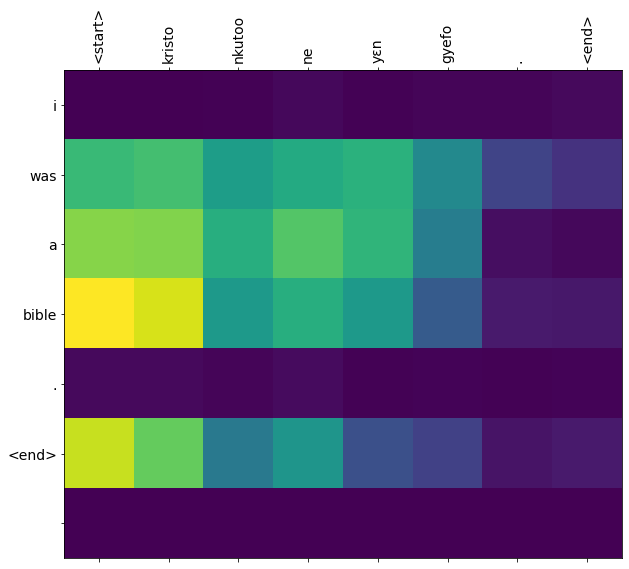

In [112]:
#translate(u'hace mucho frio aqui.')
translate(u'kristo nkutoo ne yɛn gyefo .')